# CS 356 Week Day 2 Day 1

## Monday 2021-10-05

A peak behind the magic six lines.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/defreez/cs356-notebooks/blob/main/notebooks/week2-mon-wed.ipynb)

In [91]:
from fastbook import *

# Agenda

- What are pictures (pixel tensors)
- MNIST baseline (ideal digit)
- Linear MNIST model
    - Stochastic Gradient Descent

### Our data

- MNIST
    - `URLs.MNIST_SAMPLE` has data for only `3` and `7`
    - `URLs.MNIST` has data for all digits
    - Considered easy now, but hard not too long ago
        - Some people still interested in these "easy" problems from the approach of using the smallest amount of data possible for training.
- CIFAR
    - Airplanes, birds, cars, etc.
    - Small 32x32 images
    - Has colors
    - `URLs.CIFAR`
- MNIST Fashion
    - Drop-in replacement for MNIST
    - More difficult
    - Search kaggle for MNIST fashion

In [92]:
mnist_path = untar_data(URLs.MNIST)
cifar_path = untar_data(URLs.CIFAR)

In [93]:
(mnist_path/'testing'/'3').ls()

(#1010) [Path('/root/.fastai/data/mnist_png/testing/3/5638.png'),Path('/root/.fastai/data/mnist_png/testing/3/245.png'),Path('/root/.fastai/data/mnist_png/testing/3/9548.png'),Path('/root/.fastai/data/mnist_png/testing/3/8308.png'),Path('/root/.fastai/data/mnist_png/testing/3/819.png'),Path('/root/.fastai/data/mnist_png/testing/3/6103.png'),Path('/root/.fastai/data/mnist_png/testing/3/9707.png'),Path('/root/.fastai/data/mnist_png/testing/3/5760.png'),Path('/root/.fastai/data/mnist_png/testing/3/4120.png'),Path('/root/.fastai/data/mnist_png/testing/3/4541.png')...]

In [94]:
ones = (mnist_path/'training'/'1').ls().sorted()
threes = (mnist_path/'training'/'3').ls().sorted()
sevens = (mnist_path/'training'/'7').ls().sorted()
threes

(#6131) [Path('/root/.fastai/data/mnist_png/training/3/10.png'),Path('/root/.fastai/data/mnist_png/training/3/10000.png'),Path('/root/.fastai/data/mnist_png/training/3/10011.png'),Path('/root/.fastai/data/mnist_png/training/3/10031.png'),Path('/root/.fastai/data/mnist_png/training/3/10034.png'),Path('/root/.fastai/data/mnist_png/training/3/10042.png'),Path('/root/.fastai/data/mnist_png/training/3/10052.png'),Path('/root/.fastai/data/mnist_png/training/3/1007.png'),Path('/root/.fastai/data/mnist_png/training/3/10074.png'),Path('/root/.fastai/data/mnist_png/training/3/10091.png')...]

In [95]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [96]:
array(im3).shape

(28, 28)

In [97]:
im3_t = tensor(im3)

In [98]:
df = pd.DataFrame(im3_t)

In [99]:
df.style.set_properties(**{'font-size': '6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0,0,0,0,0,0,0


In [100]:
plane_path = (cifar_path/'train'/'airplane').ls()[0]
plane_path

Path('/root/.fastai/data/cifar10/train/airplane/37648_airplane.png')

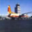

In [101]:
plane = Image.open(plane_path)
plane

In [102]:
plane_t = tensor(plane)
plane_t.shape

torch.Size([32, 32, 3])

In [103]:
plane_t[:,:,0].shape

torch.Size([32, 32])

In [104]:
plane_df = pd.DataFrame(plane_t[:,:,0])
plane_df.style.set_properties(**{'font-size': '6pt'}).background_gradient('Reds')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,85,77,77,79,82,81,82,85,85,82,79,79,80,80,79,81,82,79,79,78,79,78,77,78,78,77,75,75,74,72,70,68
1,91,84,83,86,88,86,88,93,95,93,88,88,88,88,87,86,87,87,88,85,83,83,83,83,82,80,80,81,81,80,79,75
2,95,88,88,91,95,96,95,94,94,94,95,96,96,96,93,93,95,93,97,92,88,90,91,90,88,86,86,88,89,88,86,82
3,102,95,95,98,105,107,101,96,98,100,104,105,105,105,103,103,100,99,120,108,98,102,103,101,99,96,96,99,98,97,96,93
4,112,104,104,107,113,114,107,105,112,120,118,115,114,114,114,99,67,66,94,105,114,117,116,113,110,107,107,109,108,106,105,102
5,121,113,112,113,116,116,115,126,135,136,131,122,121,120,120,97,48,52,72,93,124,127,126,123,120,117,117,118,115,112,111,109
6,126,120,119,120,118,122,126,143,199,193,146,120,128,131,117,96,51,103,167,153,138,130,129,127,127,127,127,126,123,120,117,114
7,131,127,129,130,129,133,138,139,186,219,159,123,135,142,105,61,44,108,166,167,154,136,135,133,134,135,135,133,130,128,126,121
8,141,136,137,138,141,141,142,144,169,209,171,134,134,144,107,47,40,121,192,175,159,146,143,141,142,142,140,139,136,133,133,129
9,149,142,141,143,149,146,146,157,184,226,188,145,136,142,109,56,52,125,196,193,173,153,149,147,149,147,146,144,140,138,137,136


In [105]:
plane_df = pd.DataFrame(plane_t[:,:,1])
plane_df.style.set_properties(**{'font-size': '6pt'}).background_gradient('Greens')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,134,129,131,131,131,129,128,129,129,126,125,125,126,127,127,128,129,127,126,124,122,121,122,124,125,125,125,125,124,122,120,118
1,139,135,136,136,136,134,134,136,134,131,131,133,133,134,132,133,135,133,134,132,130,128,129,130,130,129,128,128,128,127,125,122
2,140,137,138,138,138,138,140,141,140,137,136,136,137,136,134,136,139,133,136,136,135,134,135,136,135,133,131,131,132,130,128,127
3,144,141,143,143,143,143,145,147,148,147,143,141,141,142,140,141,135,126,147,145,142,143,143,143,141,140,138,138,137,135,134,133
4,151,147,150,150,150,150,149,149,149,150,150,148,147,148,147,131,90,79,108,132,151,152,151,149,147,145,145,146,144,142,141,140
5,159,155,156,155,155,156,153,156,143,132,152,154,151,151,152,123,62,55,74,110,155,158,155,154,153,151,152,152,149,146,145,144
6,164,161,163,161,163,164,157,168,178,145,149,158,151,155,153,120,61,104,162,159,161,160,158,158,158,158,156,155,153,151,149,147
7,169,168,172,171,174,174,168,157,135,140,148,167,160,162,134,77,54,112,161,168,174,167,166,164,165,166,163,161,159,158,158,154
8,177,176,179,178,179,178,178,144,85,112,146,172,170,170,123,53,48,125,189,177,179,176,173,171,172,171,170,169,167,165,167,163
9,184,180,182,182,181,180,184,143,77,115,140,167,176,175,126,60,58,129,193,195,190,181,177,175,177,175,173,173,171,169,170,169


In [106]:
plane_df = pd.DataFrame(plane_t[:,:,2])
plane_df.style.set_properties(**{'font-size': '6pt'}).background_gradient('Blues')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,209,214,211,211,214,209,207,207,207,205,205,206,205,204,202,203,206,208,209,206,203,201,202,206,209,209,208,207,207,207,207,206
1,215,220,216,217,221,219,218,216,211,207,211,214,212,211,208,209,211,209,210,212,213,210,210,213,214,214,214,214,215,216,216,214
2,214,221,217,218,221,221,224,225,222,216,215,216,214,212,208,209,208,196,200,209,216,214,214,217,217,216,216,218,219,219,219,218
3,219,225,221,223,224,222,228,232,231,225,221,220,218,216,212,210,193,174,195,208,218,220,219,221,221,220,221,223,223,223,223,223
4,225,231,228,229,230,225,226,224,214,210,223,225,222,221,219,194,137,110,138,182,220,225,223,223,222,221,223,226,226,226,226,226
5,233,238,234,233,235,232,225,217,177,157,216,232,226,223,222,182,99,73,91,149,218,226,224,224,224,224,226,229,228,226,226,226
6,233,239,235,232,232,232,230,230,166,105,194,241,237,220,215,178,98,122,173,188,215,224,225,225,227,228,231,233,232,231,231,228
7,234,241,238,235,236,238,239,222,104,61,157,236,239,219,188,129,88,129,165,185,217,227,231,230,232,234,235,234,233,233,234,230
8,240,247,242,241,245,245,240,196,65,38,123,224,231,221,168,87,77,139,188,183,209,231,234,233,236,236,234,232,231,231,233,231
9,243,248,242,241,247,247,239,180,66,44,95,212,235,236,180,92,90,147,196,200,216,231,234,233,236,236,235,234,232,233,234,234


## Ideal digit model

- A baseline
- A baseline is **IMPORTANT** **IMPORTANT** **IMPORTANT**
- For each class
    - Take the average pixel value of all of the digits in our dataset
- If a particular image is more like an ideal 3 than an ideal 7, then we call it a 3

In [107]:
one_tensors = [tensor(Image.open(o)) for o in ones]
three_tensors = [tensor(Image.open(o)) for o in threes]
seven_tensors = [tensor(Image.open(o)) for o in sevens]
stacked_ones = torch.stack(one_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_sevens = torch.stack(seven_tensors).float()/255
a_1 = stacked_ones[1]
a_3 = stacked_threes[1]
a_7 = stacked_sevens[1]

(<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>)

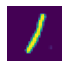

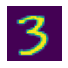

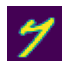

In [108]:
show_image(a_1), show_image(a_3), show_image(a_7)

## The ideal digits

- Calculate mean over axis 0
    - Axis 0 is the images themselves.
    - Calculates mean pixel value for each pixel

(torch.Size([28, 28]), <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>)

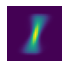

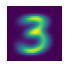

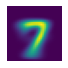

In [109]:
mean1 = stacked_ones.mean(0)
mean3 = stacked_threes.mean(0)
mean7 = stacked_sevens.mean(0)
mean3.shape, show_image(mean1), show_image(mean3), show_image(mean7)

## Validating the model

- We compute the ideal digit from the training data
- Validate the ideal digit against the validation set
    - How well does the data generalize?
    - For each digit in the validation set that is a 3 or 7
    - Compute distance between ideal digit and the validation digit
    - Use distance to classify the digit
    - Measure the error

In [110]:
valid_1_tens = torch.stack([tensor(Image.open(o)) for o in (mnist_path/'testing/'/'1').ls()])
valid_1_tens = valid_1_tens.float()/255

valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (mnist_path/'testing/'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255

valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (mnist_path/'testing/'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255

valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

## L1 Norm

- Mean absolute difference (MAE)
- A norm maps a tensor (vector) to a non-negative value
- Calculating the mean of differences between two tensors doesn't work with negatives

In [111]:
a = tensor([1, 0, 1, 0]).float()
b = tensor([0, 1, 0, 1]).float()
(a - b).mean()

tensor(0.)

In [112]:
(a-b).abs().mean()

tensor(1.)

<AxesSubplot:>

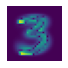

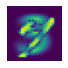

In [113]:
show_image((a_3 - mean3).abs())
show_image((a_7 - mean3).abs())

## L1 Norm as function

> "With code it's very obvious what these terms mean. With Math you just have to learn it... or Google it."

In [114]:
def mnist_distance(a, b): return (a-b).abs().mean()

mnist_distance(a_3, mean3), mnist_distance(a_3, mean7)

(tensor(0.1114), tensor(0.1586))

## Broadcasting

- For loops are the enemy
- Pass in entire validation set and calculate mnist_distance
- Get back rank-1 tensor of results
  - Map each image to its distance to another digit (ideal 3 or ideal 7)
- 🤯🤯🤯🤯🤯🤯

In [115]:
# The reason for using (-1, -2) as the dimensions is to facilitate broadcasting
# If we pass a rank3 tensor where the extra dimension is the list of images
# we want to broadcast, not take the mean of everything.
def mnist_distance(a, b): return (a-b).abs().mean((-1, -2))

mnist_distance(a_3, mean3), mnist_distance(a_3, mean7)

(tensor(0.1114), tensor(0.1586))

In [116]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1494, 0.1471, 0.1199,  ..., 0.1054, 0.1128, 0.1270]),
 torch.Size([1010]))

In [117]:
def is_3_vs_7(x): return mnist_distance(x, mean3) < mnist_distance(x, mean7)

In [118]:
is_3_vs_7(valid_3_tens).float().mean()

tensor(0.9168)

In [119]:
1 - is_3_vs_7(valid_7_tens).float().mean()

tensor(0.9854)

## Good enough?

- So, that actually worked pretty well. 
- The book kind of just moves on and says well we should make it better.
- But is it really necessary, in an absolute sense?
- Will we get 90+% accuracy using this ideal digit model?

In [120]:
def is_1_vs_7(x): return mnist_distance(x, mean1) < mnist_distance(x, mean7)

In [121]:
is_1_vs_7(valid_1_tens).float().mean()

tensor(1.)

In [122]:
1 - is_1_vs_7(valid_7_tens).float().mean()

tensor(0.7938)

### Fashion MNIST

In [123]:
### Fashion MNIST
fashion_path = untar_data('https://sou.box.com/shared/static/twlmuvbz5hjv5530aljkv76gi009s4es.tar')

In [124]:
(fashion_path/'train').ls()

(#10) [Path('/root/.fastai/data/twlmuvbz5hjv5530aljkv76gi009s4es/train/7'),Path('/root/.fastai/data/twlmuvbz5hjv5530aljkv76gi009s4es/train/0'),Path('/root/.fastai/data/twlmuvbz5hjv5530aljkv76gi009s4es/train/4'),Path('/root/.fastai/data/twlmuvbz5hjv5530aljkv76gi009s4es/train/9'),Path('/root/.fastai/data/twlmuvbz5hjv5530aljkv76gi009s4es/train/3'),Path('/root/.fastai/data/twlmuvbz5hjv5530aljkv76gi009s4es/train/1'),Path('/root/.fastai/data/twlmuvbz5hjv5530aljkv76gi009s4es/train/6'),Path('/root/.fastai/data/twlmuvbz5hjv5530aljkv76gi009s4es/train/2'),Path('/root/.fastai/data/twlmuvbz5hjv5530aljkv76gi009s4es/train/8'),Path('/root/.fastai/data/twlmuvbz5hjv5530aljkv76gi009s4es/train/5')]

In [125]:
sandals = (fashion_path/'train'/'5').ls().sorted()
sneakers = (fashion_path/'train'/'7').ls().sorted()

In [126]:
sandal_tensors = [tensor(Image.open(o)) for o in sandals]
sneaker_tensors = [tensor(Image.open(o)) for o in sneakers]
stacked_sandals = torch.stack(sandal_tensors).float()/255
stacked_sneakers = torch.stack(sneaker_tensors).float()/255
a_sandal = stacked_sandals[1]
another_sandal = stacked_sandals[0]
a_sneaker = stacked_sneakers[1]

(<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>)

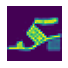

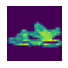

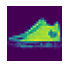

In [127]:
show_image(a_sandal), show_image(another_sandal), show_image(a_sneaker)

(<AxesSubplot:>, <AxesSubplot:>)

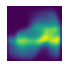

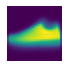

In [128]:
mean_sandal = stacked_sandals.mean(0)
mean_sneaker = stacked_sneakers.mean(0)
show_image(mean_sandal), show_image(mean_sneaker)

In [129]:
valid_sandals = torch.stack([tensor(Image.open(o)) for o in (fashion_path/'test/'/'5').ls()])
valid_sandals = valid_sandals.float()/255

valid_sneakers = torch.stack([tensor(Image.open(o)) for o in (fashion_path/'test/'/'7').ls()])
valid_sneakers = valid_sneakers.float()/255

In [130]:
def is_sneaker(x): return mnist_distance(x, mean_sneaker) < mnist_distance(x, mean_sandal)

In [131]:
is_sneaker(valid_sneakers).float().mean()

tensor(0.9550)

# Still good?!

In [132]:
1 - is_sneaker(valid_sandals).float().mean()

tensor(0.5790)

# Stochastic Gradient Descent

![](https://sebastianraschka.com/images/blog/2015/singlelayer_neural_networks_files/perceptron_neuron.png)

![](https://sebastianraschka.com/images/blog/2015/singlelayer_neural_networks_files/perceptron_gradient_descent_1.png)

![](https://sebastianraschka.com/images/blog/2015/singlelayer_neural_networks_files/perceptron_animation.gif)

Source: https://sebastianraschka.com/Articles/2015_singlelayer_neurons.html

![](https://sebastianraschka.com/images/blog/2015/singlelayer_neural_networks_files/perceptron_learning_rate.png)

### PyTorch autograd
- Automatic differentiation
- Records all of operations used
- Knows how the chain rule works-
- Automatically calculates the gradient (multi-variable derivative)
- 🤯🤯🤯🤯🤯🤯

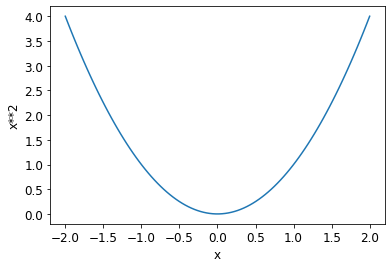

In [133]:
def f(x): return x**2
plot_function(f, 'x', 'x**2')

In [134]:
# Create a tensor of the input and track it for autograd
xt = tensor(3.).requires_grad_()
    
# Compute y = f(x)
yt = f(xt)
    
# Compute df/dx
yt.backward()
    
# Return df/dx at x = input
xt.grad

tensor(6.)

## Create the training set



In [135]:
# Concatenates sevens onto threes
# Then turns each 28x28 matrix into a 784 vector (28*28 = 784)
# -1 is placeholder for whatever size is necessary. In this case 12396 (length of threes + length of sevens)
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
stacked_threes.shape, stacked_sevens.shape, train_x.shape

(torch.Size([6131, 28, 28]),
 torch.Size([6265, 28, 28]),
 torch.Size([12396, 784]))

In [136]:
# Labels of the images (1 is a 3, 0 is a 7)
# Unsqueeze turns this vector into a row per element by adding dimension 1
train_y = tensor([1]*len(threes) + [0]*len(sevens))
train_y.shape

torch.Size([12396])

In [137]:
# Pair up the x's with the y's
dset = list(zip(train_x, train_y))
train_x.shape, train_y.shape, len(dset)

(torch.Size([12396, 784]), torch.Size([12396]), 12396)

### Create the validation set

- Same process as creating training set
- Just different tensors

In [138]:
# Create the validation set. Same process as before, different tensors.
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens))
valid_dset = list(zip(valid_x, valid_y))
valid_x.shape, valid_y.shape, len(valid_dset)

(torch.Size([2038, 784]), torch.Size([2038]), 2038)

In [139]:
# Initialize random weights for vectors.
# Single-layer network will learn a function of the form y = wx + b
# Single layer network (linear-only). Only capable of learning linearly-separable patterns.
# Would be interesting to do this in two dimensions with visualization for a lab.
def init_params(size, std=1.0): return(torch.randn(size)*std).requires_grad_()
weights = init_params((28*28, 1))
bias = init_params(1)
weights.shape

torch.Size([784, 1])

In [140]:
train_x.shape, train_x[0].shape, weights.shape

(torch.Size([12396, 784]), torch.Size([784]), torch.Size([784, 1]))

In [141]:
# Predict an image. How do we interpret the prediction?
(train_x[0]*weights).sum()

tensor(2729.8242, grad_fn=<SumBackward0>)

### Linear model

- We want to comput the weighted sum of each image in the training data
    - These are our predictions
- `@` is matrix multiplication

In [142]:
a = tensor([[1., 2.], [3., 4.], [4, 4]])
b = tensor([[1.], [0.5]])
a.shape, b.shape, a@b, (a@b).shape

(torch.Size([3, 2]),
 torch.Size([2, 1]),
 tensor([[2.],
         [5.],
         [6.]]),
 torch.Size([3, 1]))

In [143]:
tensor(([1, 2]))@tensor(([3,4]))

tensor(11)

In [144]:
weights.shape

torch.Size([784, 1])

In [145]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds.shape, preds

(torch.Size([12396, 1]),
 tensor([[  1.1869],
         [  4.5665],
         [  0.5517],
         ...,
         [-14.9503],
         [  5.1521],
         [ -7.9406]], grad_fn=<AddBackward0>))

In [146]:
# Interpret > 0 as a 3, and <= 0 as a 7.
# Then with this function we predict basically everything as a three, which is 50% accuracy.
# Not sure if there it is worthwhile showing this prediction portion since we throw it away anyway
# It gets all 3s correct and all 7's incorrect ... not sure what the point is
# Move on to loss function where predictions are between 0 and 1
corrects = (preds>0.0).float()  == train_y
corrects

tensor([[ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        ...,
        [False, False, False,  ...,  True,  True,  True],
        [ True,  True,  True,  ..., False, False, False],
        [False, False, False,  ...,  True,  True,  True]])

In [147]:
corrects.float().mean().item()

0.5015496611595154

### A loss function that we can optimize
- Close to continuous so that gradient descent can work with it
- Number of correct predictions therefore doesn't work as well
- We want a loss function that is between 0 and 1
- Indicates how close the prediction is 
- Loss is for the machines
- Accuracy is for humans

In [148]:
trgts = tensor([1,0,1])
prds = tensor([0.9, 0.4, 0.2])

def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [149]:
mnist_loss(prds, trgts)

tensor(0.4333)

## Sigmoid

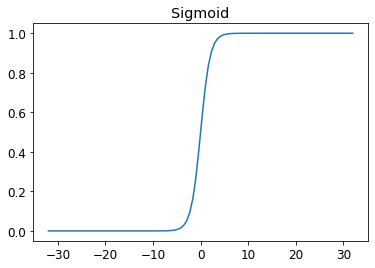

In [150]:
plot_function(torch.sigmoid, title='Sigmoid', min=-32, max=32)

In [151]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [152]:
mnist_loss(prds, trgts)

tensor(0.4460)

# **Stochastic** Gradient Descent and Mini-Batches

- Gradient Descent calculates loss function over entire training data set
- *Stochastic* Gradient Descent calculates loss over part of training data set
- A batch reduces the number of items that a gradient is calculated over.
- An epoch goes over entire data set (all of the batches) once.

## Initialize the weights

- One weight per pixel in the data
- Still have a bias

In [153]:
weights = init_params((28*28, 1))
bias = init_params(1)

## Create our batches

- DataLoader class pairs up data with class labels
  - One for training data
  - One for validation data. 
    - In this slide set using MNIST testing as validation data.

In [154]:
dl = DataLoader(dset, batch_size=1024)
xb, yb = first(dl)
xb.shape, yb.shape

(torch.Size([1024, 784]), torch.Size([1024]))

In [155]:
valid_dl = DataLoader(valid_dset, batch_size=1024)
len(valid_dset)

2038

## Create predictions

In [156]:
batch = train_x[:4]

In [157]:
preds = linear1(batch)
preds

tensor([[ 3.8978],
        [-1.0354],
        [-2.1836],
        [12.2071]], grad_fn=<AddBackward0>)

## Calculate loss and gradient
- Get the gradient
    - Tensor of 784 slopes
    - Slope of weight associated with each pixel

In [158]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.4142, grad_fn=<MeanBackward0>)

In [159]:
loss.backward()
weights.grad.shape

torch.Size([784, 1])

In [160]:
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(-0.0108), tensor([-0.0760]))

## Gradient calculation function

- I've tweaked this slightly from the book example so that it runs in isolation

1. Calculate predictions
2. Calculate loss based on predictions
3. Calculate gradient

In [161]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [162]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(), bias.grad

(tensor(-0.0217), tensor([-0.1519]))

## Training an Epoch
    
- An epoch is one time through all batches in the dataset
- For each batch calculate gradient

In [163]:
def train_epoch(model, lr, params):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad * lr
            p.grad.zero_()

## Get Validation accuracy

In [164]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds > 0.5) == yb
    return correct.float().mean()

In [165]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [166]:
## Train Everything

In [167]:
lr = 1.
params = weights, bias
for i in range(100):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end= ' ')

0.5002 0.5121 0.5938 0.7467 0.805 0.8762 0.908 0.9227 0.9313 0.9351 0.9379 0.9398 0.9417 0.9441 0.9465 0.947 0.9475 0.9494 0.9489 0.9493 0.9493 0.9498 0.9498 0.9508 0.9512 0.9512 0.9512 0.9512 0.9522 0.9527 0.9532 0.9532 0.9532 0.9527 0.9527 0.9531 0.9536 0.9546 0.9551 0.9551 0.9551 0.9556 0.9561 0.9565 0.9565 0.9565 0.9575 0.9575 0.9575 0.9575 0.9575 0.9575 0.9575 0.9575 0.9575 0.957 0.957 0.957 0.9575 0.9575 0.958 0.9589 0.9589 0.9594 0.9594 0.9599 0.9604 0.9614 0.9614 0.9614 0.9614 0.9614 0.9619 0.9619 0.9623 0.9623 0.9623 0.9623 0.9623 0.9623 0.9623 0.9623 0.9623 0.9623 0.9623 0.9623 0.9623 0.9623 0.9623 0.9623 0.9628 0.9628 0.9628 0.9628 0.9633 0.9633 0.9633 0.9633 0.9633 0.9633 

# Interpreting the weights

- They work
- Do they make any sense?
- Not really
- Interpreting neural network internals is often difficult

<AxesSubplot:>

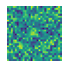

In [168]:
# Try and interpret the weights as an image.
flat_pixels = (weights.sigmoid()*255).squeeze()
show_image(flat_pixels.view(28, 28))

#### Creating an Optimizer

In [169]:
linear_model = nn.Linear(28*28, 1)

In [170]:
w, b = linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [171]:
class BasicOptim:
    def __init__(self, params, lr):
        self.params, self.lr = list(params), lr
    
    def step(self, *args, **kwargs):
        for p in self.params:
            p.data -= p.grad.data * self.lr
        
    def zero_grad(self, *args, **kwargs):
        for p in self.params:
            p.grad = None

In [172]:
opt = BasicOptim(linear_model.parameters(), 1.)

In [173]:
def train_epoch2(model):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [174]:
validate_epoch(linear_model)

0.4806

In [175]:
def train_model2(model, epochs):
    for i in range(epochs):
        train_epoch2(model)
        print(validate_epoch(model), end=' ')

In [176]:
train_model2(linear_model, 20)

0.4932 0.4932 0.4932 0.4932 0.4932 0.8335 0.9127 0.9322 0.9464 0.9521 0.9521 0.954 0.9549 0.9558 0.9587 0.9587 0.9606 0.9616 0.9616 0.962 

Using the FastAI class

In [177]:
linear_model_fastai = nn.Linear(28*28, 1)
opt = SGD(linear_model_fastai.parameters(), lr)
train_model2(linear_model_fastai, 20)

0.4932 0.4932 0.4932 0.4932 0.4946 0.797 0.9151 0.9317 0.9469 0.9521 0.9531 0.9544 0.9549 0.9558 0.9587 0.9587 0.9606 0.9616 0.9621 0.9621 

In [178]:
dls = DataLoaders(dl, valid_dl)
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)

In [179]:
# Required to get the learner to use the GPU (as reported by nvidia-smi)
# Doesn't provide much speed up for simple linear classifier
learn.model = learn.model.cuda()

In [180]:
%%time
learn.fit(10, lr=0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.410925,0.326177,0.743974,00:01
1,0.291243,0.222172,0.876121,00:00
2,0.228339,0.150978,0.930462,00:00
3,0.186931,0.120992,0.940868,00:00
4,0.158063,0.105424,0.948464,00:00
5,0.136937,0.095810,0.950346,00:00
6,0.120897,0.089196,0.950810,00:00
7,0.108379,0.084304,0.950796,00:00
8,0.098402,0.080507,0.951273,00:00
9,0.090317,0.077454,0.951751,00:00


CPU times: user 1.58 s, sys: 363 ms, total: 1.95 s
Wall time: 2.44 s


### Adding a Nonlinearity

In [181]:
simple_net = nn.Sequential(
    nn.Linear(28*28, 784),
    nn.ReLU(),
    nn.Linear(784, 30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [182]:
%%time
learn = Learner(dls, simple_net, opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)
learn.model = learn.model.cuda()
learn.fit(100, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.504946,0.483627,0.832497,00:00
1,0.485536,0.448891,0.773551,00:00
2,0.448866,0.373980,0.708179,00:00
3,0.383102,0.271931,0.808881,00:00
4,0.309276,0.162284,0.902834,00:00
5,0.246422,0.108640,0.931416,00:00
6,0.197853,0.085445,0.946185,00:00
7,0.160968,0.073407,0.949922,00:00
8,0.132838,0.066116,0.950399,00:00
9,0.111186,0.061229,0.951831,00:00


CPU times: user 11.6 s, sys: 267 ms, total: 11.8 s
Wall time: 11.6 s


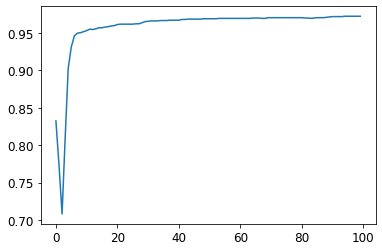

In [183]:
plt.plot(L(learn.recorder.values).itemgot(2))

## Handling more than one digit

- This is lab 2
- Cross-entropy loss
    - Read the section in chapter 5
- Works even when there is more than two categories

### Softmax

- Serves the same purpose as sigmoid
- Ensures all activations are between 0 and 1
- Also that sum of activations is 1